# Amtrak linestrings are funky

* Some of the linestrings look funky, is this from what we're doing in assembling the df or in the original?
* **Finding**: there are actually wrong shapes in the original downloaded...it looks like some of the coords in that sequence is oscillating. 
* **Decision**: use a cut-off of 3,500 miles in general to throw out anything that is way too long. Although, this wouldn't really solve any issue if a shape looked weird within CA.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'

import dask.dataframe as dd
import dask_geopandas as dg
import geopandas as gpd
import intake
import pandas as pd
from segment_speed_utils import helpers
from segment_speed_utils.project_vars import COMPILED_CACHED_VIEWS, analysis_date
from calitp_data_analysis import utils

TRAFFIC_OPS_GCS = "gs://calitp-analytics-data/data-analyses/traffic_ops/"

SHARED_DATA = "../_shared_utils/shared_utils/shared_data_catalog.yml"
catalog = intake.open_catalog(SHARED_DATA)

WGS84 = "EPSG:4326"

In [ ]:
gdf = gpd.read_parquet(f"{TRAFFIC_OPS_GCS}ca_transit_routes.parquet", 
                       filters = [[("agency", "==", "Amtrak")]]
                      )

In [ ]:
gdf.plot("route_id")

## Narrow down routes that fall outside CA

* Any shape that is weird, whether or not it's Amtrak, needs to be dropped

In [ ]:
ca_counties = catalog.ca_counties.read()[["geometry"]].dissolve().to_crs(WGS84)

In [ ]:
gdf[gdf.agency == "Amtrak"].plot()

In [ ]:
gdf2 = gpd.sjoin(
    gdf, 
    ca_counties, 
    how="inner", 
    predicate="within"
).drop(
    columns="index_right"
)

In [ ]:
# Just keep those that did not merge with being in CA (left_only)
merge_cols = [c for c in gdf.columns if c != "geometry"]

outside_ca = (
    pd.merge(
        gdf, gdf2.drop(columns="geometry"), on=merge_cols, how="left", indicator=True
    )
    .query("_merge == 'left_only'")
    .drop(columns="_merge")
    .dropna(subset="geometry")
).reset_index(drop=True)

In [ ]:
outside_ca.agency.value_counts()

Most rows are Greyhound.

Test hypothesis that Greyhound and Amtrak are ones that might show something erroneous.

**Finding**: It's Amtrak that has some lines that are ok and some are funky

In [ ]:
# Most values are Greyhound,
# Plotting all these, only Amtrak has some erroneous shapes
outside_ca[outside_ca.agency != "Amtrak"].plot()

In [ ]:
bad_ca = outside_ca[outside_ca.agency == "Amtrak"].reset_index(drop=True)

In [ ]:
bad_ca.plot("agency")

The lines that are extremely long would have overly long lengths. The longest Amtrak line is Zephyr, which runs for 2,438 miles, so let's give a larger range than that to be safe. 

In [ ]:
gddf = dg.from_geopandas(bad_ca, npartitions=2)

In [ ]:
route_length_feet = gddf.geometry.to_crs("EPSG:2229").length

route_length_mi = route_length_feet / 5280

gddf["route_length_mi"] = route_length_mi

In [ ]:
gddf = gddf.persist()

In [ ]:
gddf.route_length_mi.describe().compute()

In [ ]:
CUTOFF = 3_500
extreme = gddf[gddf.route_length_mi > CUTOFF].compute()
ok = gddf[gddf.route_length_mi <= CUTOFF].compute()

In [ ]:
extreme.plot()

In [ ]:
ok.plot("shape_id")

In [ ]:
print(f"# rows in extreme: {len(extreme)}")
print(f"# rows in ok: {len(ok)}")

## Grab the erroneous shape_ids from original downloaded shapes and check

In [ ]:
extreme_shape_ids = extreme.shape_id.unique().tolist()
extreme_route_ids = extreme.route_id.unique().tolist()

extreme_trips = helpers.import_scheduled_trips(
    analysis_date,
    filters=[
        [("name", "==", "Amtrak Schedule"), ("route_id", "in", extreme_route_ids)]
    ],
    columns=["feed_key", "name", "shape_id", "route_id", "shape_array_key"],
    get_pandas=True,
).dropna(subset="shape_array_key")

In [ ]:
extreme_shapes = helpers.import_scheduled_shapes(
    analysis_date,
    filters=[[("shape_id", "in", extreme_shape_ids)]],
    columns=["feed_key", "shape_id", "shape_array_key", "geometry"],
    get_pandas=True,
)

In [ ]:
extreme_shapes.plot("shape_id")

## original shapes are ok, check step-by-step in the functions

In [5]:
routes = create_routes_data.create_routes_file_for_export(analysis_date)  

In [6]:
routes3 = create_routes_data.finalize_export_df(
    routes)

<AxesSubplot:>

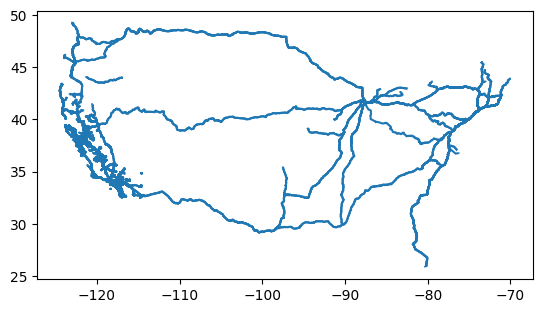

In [7]:
routes3.plot()

In [8]:
utils.geoparquet_gcs_export(
        routes3, 
        TRAFFIC_OPS_GCS, 
        "ca_transit_routes"
    )


<AxesSubplot:>

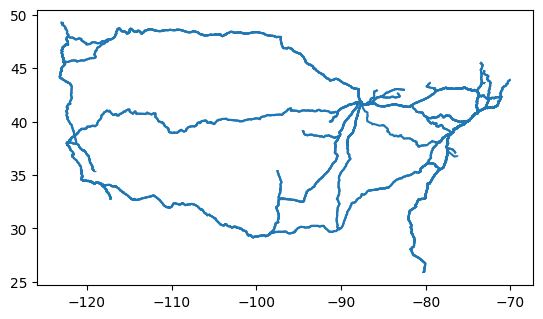

In [10]:
routes3[routes3.agency=="Amtrak"].plot()

In [11]:
gdf_new = gpd.read_parquet(f"{TRAFFIC_OPS_GCS}ca_transit_routes.parquet", 
                       filters = [[("agency", "==", "Amtrak")]]
                      )

<AxesSubplot:>

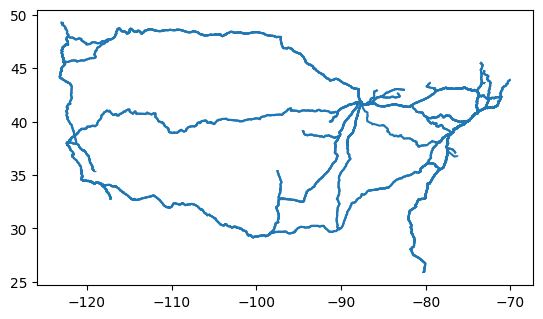

In [12]:
gdf_new.plot()